# Real-Time Concrete Crack Detection and Classification using Transfer Learning CNN with Masking Techniques
### Members: 
* Anacio, Jemuel O.
* Capinpin, Marc Kristofer A.
* Gonzales, Krizelle Mae B.


Dataset: https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification/data

## 1. Import Dependencies

In [1]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


## 2. Data Pre-Processing
    2.0 Data Exploration
    2.1 Data Splitting
    2.2 Data Augmentation
    2.3 Data Loading Function

### 2.0 Data Exploration

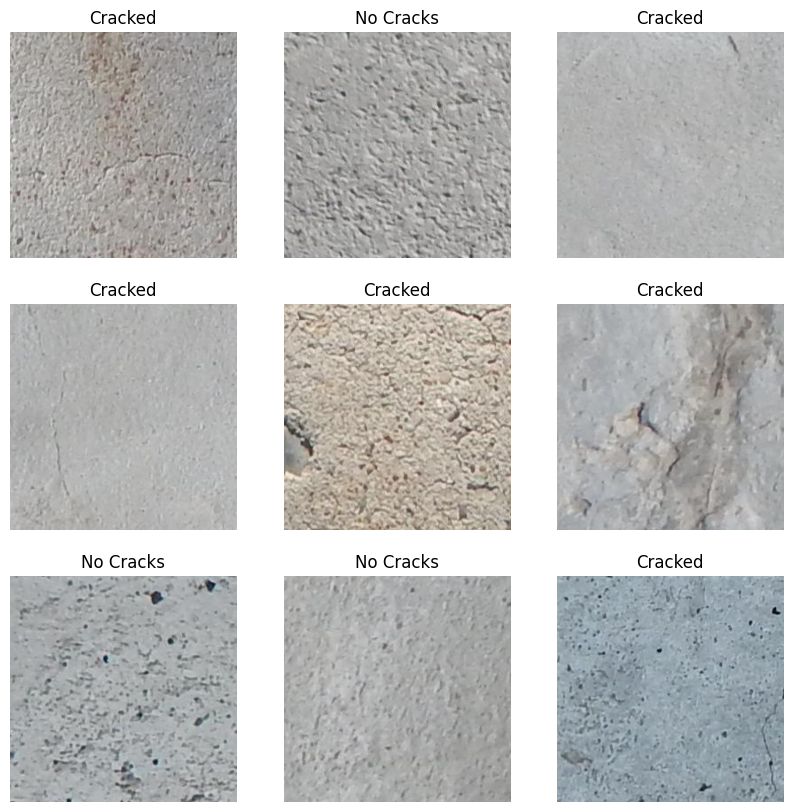

Number of cracked samples: 8484
Number of no cracks samples: 47608


In [2]:
data_path = 'data/Dataset (Focal)'

num_samples = 9

classes = ['Cracked', 'No Cracks']

# Display `num_samples` random samples from the dataset
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(num_samples):
    class_name = random.choice(classes)

    # Load the image
    img_path = os.path.join(data_path, f'{class_name}/{random.choice(os.listdir(os.path.join(data_path, class_name)))}')
    img = mpimg.imread(img_path)

    # Display the image
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(class_name)

plt.show()

# Display the number of samples in the dataset
num_positive_samples = len(os.listdir(os.path.join(data_path, 'Cracked')))
num_negative_samples = len(os.listdir(os.path.join(data_path, 'No Cracks')))
print('Number of cracked samples:', num_positive_samples)
print('Number of no cracks samples:', num_negative_samples)

In [5]:
# Renaming the files in the dataset folder with same name to other class to avoid confusion
no_cracks_path = "data/dataset/no cracks"
cracked_path = "data/dataset/cracked"

no_cracks_files = os.listdir(no_cracks_path)
cracked_files = os.listdir(cracked_path)

for cracked_file in cracked_files:
    if cracked_file in no_cracks_files:
        new_name = "cracked_" + cracked_file 
        old_file_path = os.path.join(cracked_path, cracked_file)
        new_file_path = os.path.join(cracked_path, new_name)
        os.rename(old_file_path, new_file_path)

### 2.1 Data Splitting

In [6]:
import splitfolders
splitfolders.ratio('data/dataset', output="data/split_data", seed=1337, ratio=(0.7, 0.1, 0.2)) 

In [4]:
# Sampling 5000 each class from the Focal Paper's dataset
src_dir = 'data/dataset (focal)'
dst_dir = 'data/sample_data (focal)'

class_names = ['cracked', 'no cracks']
for class_name in class_names:
    dst_class_dir = os.path.join(dst_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

num_images = 5000

for class_name in class_names:
    src_class_dir = os.path.join(src_dir, class_name)
    dst_class_dir = os.path.join(dst_dir, class_name)
    files = os.listdir(src_class_dir)
    files = sorted(files)

    for i, filename in enumerate(files):
        if i >= num_images:
            break

        src_file = os.path.join(src_class_dir, filename)
        dst_file = os.path.join(dst_class_dir, filename)

        shutil.copy(src_file, dst_file)

In [7]:
# Splitting the data new sample data from focal paper's dataset
splitfolders.ratio('data/sample_data (focal)', output="data/split_data", seed=1337, ratio=(0.7, 0.1, 0.2)) 

In [ ]:
from PIL import Image

# Resizing the images to (224, 224)
def resize_images_in_folder(folder_path, target_size):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path)
                resized_img = img.resize(target_size, Image.LANCZOS)      
                resized_img.save(file_path)
                print(f"Resized {filename} to {target_size}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

target_size = (224, 224)
resize_images_in_folder('data/split_data/train/cracked', target_size)
resize_images_in_folder('data/split_data/train/no cracks', target_size)
resize_images_in_folder('data/split_data/test/cracked', target_size)
resize_images_in_folder('data/split_data/test/no cracks', target_size)
resize_images_in_folder('data/split_data/val/cracked', target_size)
resize_images_in_folder('data/split_data/val/no cracks', target_size)

### 2.3 Data Loading Function

In [2]:
batch_size = 32
img_size = (224, 224)

# Define the data loaders for training and test sets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/train',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/test',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
    )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/val',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
    )

Found 35000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [3]:
class_names = train_data.class_names
print(class_names)

['cracked', 'no cracks']


In [4]:
# Rescale the pixel values to be between 0 and 1
train_data = train_data.map(lambda x, y: (x / 255., y))
test_data = test_data.map(lambda x, y: (x / 255., y))
val_data = val_data.map(lambda x, y: (x / 255., y))

# Shuffle and prefetch the data for better performance
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# checking the shape of the data
print("Train data shape:", train_data.element_spec)
print("Validation data shape:", val_data.element_spec)
print("Test data shape:", test_data.element_spec)

Train data shape: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Validation data shape: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Test data shape: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))


In [5]:
# # Define the augmentation function

# def augment(image, label):
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_flip_up_down(image)
#   image = tf.image.random_brightness(image, max_delta=0.1)
#   image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
#   return image, label

# # Apply the augmentation function to the training dataset
# train_data = train_data.shuffle(buffer_size=1000)
# train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# # Apply the same augmentation function to the validation dataset
# val_data = val_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

d:\Programming\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Building the model

In [7]:
# Load the EfficientNetB0 model pre-trained on ImageNet without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers[:-10]:
  layer.trainable = True

# Increase model complexity by adding more layers
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Increased units from 128 to 256
    layers.Dropout(0.3),  # Increased dropout rate
    layers.Dense(len(class_names), activation='softmax')
])

# Adjust the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
loss = tf.keras.losses.CategoricalCrossentropy()


# Compile the model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [6]:
# from keras.applications import EfficientNetB0
# from keras.layers import Flatten, Dense
# from keras.models import Model

# # Load the pre-trained EfficientNetB0 model with input shape
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Unfreeze the top 10 layers of the base model
# for layer in base_model.layers[-10:]:
#     layer.trainable = True

# # Add custom layers on top of the base model
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

# optimizer = Adam(learning_rate=0.0001)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

## Model fitting

In [8]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data
)

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3892s 3s/step - accuracy: 0.9386 - loss: 0.1477 - val_accuracy: 0.6324 - val_loss: 0.6986
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3527s 3s/step - accuracy: 0.9764 - loss: 0.0664 - val_accuracy: 0.5900 - val_loss: 6644.6748
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3743s 3s/step - accuracy: 0.9822 - loss: 0.0506 - val_accuracy: 0.5156 - val_loss: 0.9624
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3778s 3s/step - accuracy: 0.9835 - loss: 0.0453 - val_accuracy: 0.5014 - val_loss: 2294.4092
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3813s 3s/step - accuracy: 0.9850 - loss: 0.0384 - val_accuracy: 0.7434 - val_loss: 0.7168
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3858s 4s/step - accuracy: 0.9860 - loss: 0.0384 - val_accuracy: 0.4976 - val_loss: 1013.6208
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4015s 4s/step - accuracy: 0.9873 - loss: 0.0352 - val_accuracy: 0.4964 - val_loss: 17.8288
Epoch 8/20
  96/1094 ━━━━━━━━━━━━━━━━━━━━ 1:00:29 4s/step - accura

In [45]:
for images, labels in train_data.take(1):  # Take a single batch
    print("Batch shape:", images.shape)  # Print batch shape
    print("Labels shape:", labels.shape)  # Print labels shape
    labels_array = np.array(labels)
    print("Sample Labels:", labels_array[:5])

Batch shape: (32, 224, 224, 3)
Labels shape: (32, 2)
Sample Labels: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [17]:
for images, labels in val_data.take(1):  # Take a single batch
    print("Batch shape:", images.shape)  # Print batch shape
    print("Labels shape:", labels.shape)  # Print labels shape
    labels_array = np.array(labels)
    print("Sample Labels:", labels_array[:5])

Batch shape: (32, 224, 224, 3)
Labels shape: (32, 2)
Sample Labels: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


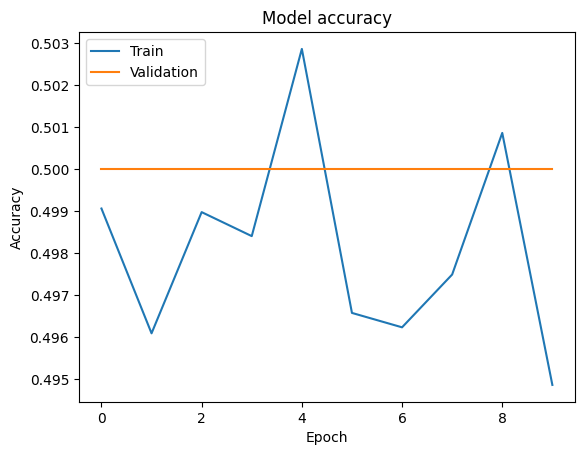

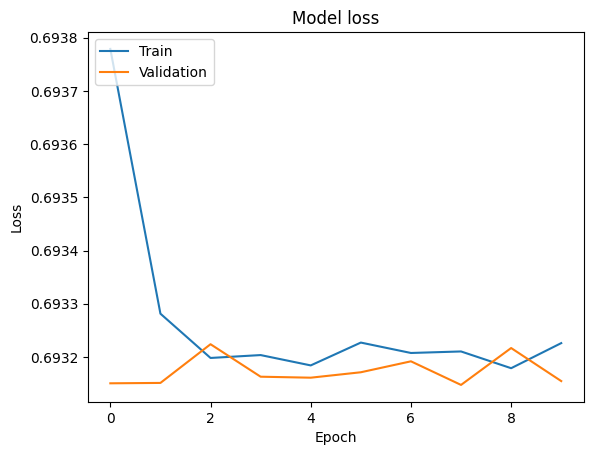

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
model.save('model3.h5')

TypeError: cannot pickle 'module' object

## Testing the Model

In [57]:
# Assuming you have a test data generator 'test_data'
test_data_dir = 'data/split_data/test'

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

ValueError: No model config found in the file at model3.h5.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
class_labels = ['no cracks', 'cracked']

# Get a batch of images and their true labels from the test data dataset
batch_images, batch_labels = next(iter(test_data))

# Normalize the pixel values to be between 0 and 1
batch_images = batch_images / 255.0

# Make predictions on the batch of images
predictions = model.predict(batch_images)

# Set up a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the batch to display images and predicted classes
for i in range(9):
    image = batch_images[i]
    true_label = class_labels[int(batch_labels[i])]
    predicted_label = class_labels[int(predictions[i]>0.5)]  # Assuming threshold of 0.5 for binary classification

    # Display the image on the current subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')

    # Add a title to the subplot
    title = f'True Class: {true_label}, Predicted Class: {predicted_label}'
    ax.set_title(title, fontsize=7)

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plot
plt.show()
    

NameError: name 'test_data' is not defined